<a href="https://colab.research.google.com/github/Vagdevi-Gandhala/Youtube-API-analysis/blob/main/YOUTUBE_API_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Extraction from Youtube data Api

## Import required libraries

In [1]:
from googleapiclient.discovery import build
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

##copy the api key generated in google cloud services

In [80]:
api_key = '' #YOUR API KEY HERE
channel_id = 'UC2D2CMWXMOVWx7giW1n3LIg'
youtube = build('youtube', 'v3', developerKey = api_key)

##function to get channel statistics

In [81]:
def get_channel_stats(youtube, channel_id):

  all_data = []

  request = youtube.channels().list(
      part='snippet,contentDetails,statistics',id = channel_id)

  response = request.execute()

  #loop through items
  for item in response['items']:
    data = {'channel Name' : item['snippet']['title'],
            'playlist_id' : item['contentDetails']['relatedPlaylists']['uploads']
            }
    all_data.append(data)        

  return all_data

In [82]:
channel_statistics = get_channel_stats(youtube, channel_id)

In [83]:
channel_data = pd.DataFrame(channel_statistics)
channel_data


,channel Name,playlist_id
0,Andrew Huberman,UU2D2CMWXMOVWx7giW1n3LIg


In [84]:
playlist_id = 'UU2D2CMWXMOVWx7giW1n3LIg'

##function to get video ids


In [85]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids


In [86]:
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

89

##function to get video details

In [88]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'title': video['snippet']['title'], 'description': video['snippet']['description'],
                             'view_count':video['statistics']['viewCount'],'like_count':video['statistics']['likeCount']
                            }
        
            all_video_info.append(stats_to_keep)
    
    return pd.DataFrame(all_video_info)

In [89]:
video_df =  get_video_details(youtube, video_ids)
video_df

,title,description,view_count,like_count
0,LIVE EVENT Q&A: Dr. Andrew Huberman Question &...,Recently I had the pleasure of hosting two liv...,85525,3508
1,"Dr. Peter Attia: Exercise, Nutrition, Hormones...","My guest this episode is Dr. Peter Attia, M.D....",285347,8821
2,Sleep Toolkit: Tools for Optimizing Sleep & Sl...,"In this episode, I describe a comprehensive to...",246789,8577
3,Dr. Emily Balcetis: Tools for Setting & Achiev...,"My guest this episode is Dr. Emily Balcetis, P...",190051,6409
4,The Science & Treatment of Bipolar Disorder | ...,"In this episode, I explain the biology, sympto...",131985,3890
...,...,...,...,...
84,Find Your Temperature Minimum to Defeat Jetlag...,"In this episode, I discuss a simple and reliab...",258679,8365
85,"Using Science to Optimize Sleep, Learning & Me...","“Office Hours” — In this episode, I answer you...",838616,26652
86,Master Your Sleep & Be More Alert When Awake |...,Today's episode provides a host of information...,1698628,55944
87,How Your Nervous System Works & Changes | Hube...,Today’s episode provides an introduction to ho...,842057,39336


#data pre-processing

###check is there are any null values

In [55]:
video_df.isnull().any()

title          False
description    False
view_count     False
like_count     False
dtype: bool

###Check data types

In [56]:
video_df.dtypes

title          object
description    object
view_count     object
like_count     object
dtype: object

###Convert count columns to numeric

In [90]:
numeric_cols = ['view_count', 'like_count']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

#Exploratory Data Analysis


##Best performing videos

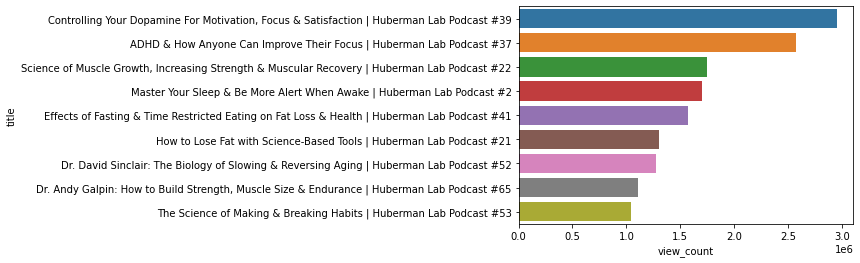

In [91]:
ax = sns.barplot(x = 'view_count', y = 'title', data = video_df.sort_values('view_count', ascending=False)[0:9])


##Worst Performing videos

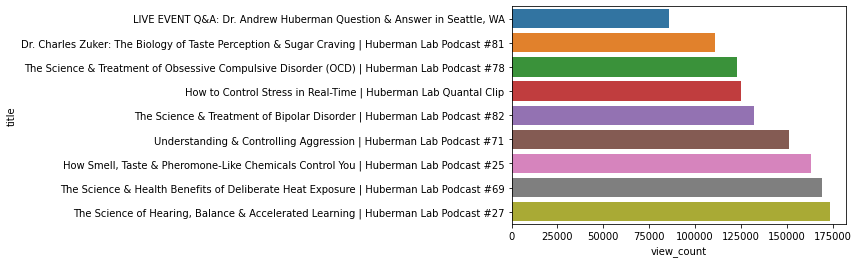

In [92]:
ax = sns.barplot(x = 'view_count', y = 'title', data = video_df.sort_values('view_count', ascending=True)[0:9])


##Views vs. likes

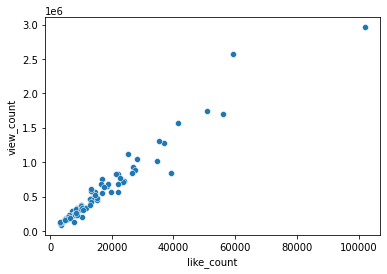

In [93]:
sns.scatterplot(data = video_df, x = 'like_count', y = 'view_count')
